In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pip install pmdarima
# !pip install fbprophet


## **IMPORTS**

In [3]:
import numpy as np
import pandas as pd
from functools import reduce
from six.moves import cPickle as pickle
import pickle as _pickle
from statsmodels.tsa.seasonal import seasonal_decompose
#import matplotlib.pylab as plt
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from IPython.display import display_html, display, HTML 
import random
from pmdarima.arima import auto_arima
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
import plotly.express as px
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

# **IMPORTAR DADOS**

In [4]:
df0 = pd.read_pickle('/content/drive/MyDrive/PatriciaDiniz/linktt/link-(578, 579).pkl').drop(['trip_id', '_id', 'link',], axis=1)
df1 = pd.read_pickle('/content/drive/MyDrive/PatriciaDiniz/linktt/link-(579, 580).pkl').drop(['trip_id', '_id', 'link'], axis=1)
dataset = pd.merge(df0,df1,how='inner', on=['hour','weekday','month', 'travel_id'],suffixes=('_578_579', '_579_580'))
dataset = dataset.drop(['travel_id', 'ltt_578_579', 'ltt_579_580'], axis=1)
dataset.head()


,aproxlinkstart_578_579,hour,weekday,month,aproxlinkstart_579_580
0,2017-01-02 06:29:58.296,6,2,1,2017-01-02 06:32:00.239
1,2017-01-02 07:01:50.285,7,2,1,2017-01-02 07:06:42.592
2,2017-01-02 07:12:21.653,7,2,1,2017-01-02 07:14:41.485
3,2017-01-02 07:31:42.481,7,2,1,2017-01-02 07:41:02.046
4,2017-01-02 07:52:21.950,7,2,1,2017-01-02 07:58:37.849


In [5]:
ts = dataset
ts['ltt'] = [(e-d).total_seconds() for d, e in zip(dataset['aproxlinkstart_578_579'], dataset['aproxlinkstart_579_580'])]
ts['month']= ts['aproxlinkstart_578_579'].dt.month
# ts['day']= ts['aproxlinkstart_578_579'].dt.day
ts.index = dataset['aproxlinkstart_578_579']
ts = ts.drop(['aproxlinkstart_578_579', 'aproxlinkstart_579_580' ], axis=1)
ts

,hour,weekday,month,ltt
aproxlinkstart_578_579,,,,
2017-01-02 06:29:58.296,6,2,1,121.943
2017-01-02 07:01:50.285,7,2,1,292.307
2017-01-02 07:12:21.653,7,2,1,139.832
2017-01-02 07:31:42.481,7,2,1,559.565
2017-01-02 07:52:21.950,7,2,1,375.899
...,...,...,...,...
2017-09-29 21:48:50.598,21,6,9,227.229
2017-09-29 22:35:03.608,22,6,9,156.542
2017-09-29 23:17:59.121,23,6,9,173.698


## **TRATANDO DADOS INCONSISTENTES**

In [6]:
grafico = px.box(ts, y='ltt')
grafico.show()

In [7]:
ts.describe()

,hour,weekday,month,ltt
count,9423.000000,9423.000000,9423.000000,9423.000000
mean,13.926669,3.912767,5.293749,166.836930
std,5.310207,1.415725,2.532550,74.322223
min,6.000000,2.000000,1.000000,-7.238000
25%,9.000000,3.000000,3.000000,120.765500
50%,14.000000,4.000000,5.000000,148.872000
75%,19.000000,5.000000,8.000000,204.158500
max,23.000000,6.000000,9.000000,940.652000


In [8]:
ts_mean = ts.describe()
ts_mean = ts_mean.T
ts.loc[ts.ltt < 80, 'ltt']  = ts_mean['mean']['ltt']
ts.loc[ts.ltt < 80, 'ltt']

Series([], Name: ltt, dtype: float64)

In [9]:
ts_mean = ts.describe()
ts_mean = ts_mean.T
ts.loc[ts.ltt > 350, 'ltt']  = ts_mean['mean']['ltt']
ts.loc[ts.ltt > 350, 'ltt']

Series([], Name: ltt, dtype: float64)

In [10]:
ts.describe()

,hour,weekday,month,ltt
count,9423.000000,9423.000000,9423.000000,9423.000000
mean,13.926669,3.912767,5.293749,166.126060
std,5.310207,1.415725,2.532550,55.140259
min,6.000000,2.000000,1.000000,80.019000
25%,9.000000,3.000000,3.000000,124.794000
50%,14.000000,4.000000,5.000000,155.115000
75%,19.000000,5.000000,8.000000,196.702500
max,23.000000,6.000000,9.000000,349.922000


In [11]:
grafico = px.box(ts, y='ltt')
grafico.show()

In [12]:
  fator = 1.5
  q3, q1 = np.percentile(ts['ltt'], [75, 25])
  iqr = q3 - q1
  lowpass = q1 - (iqr * fator)
  highpass = q3 + (iqr * fator)
print(lowpass, highpass)
ts = ts.loc[(ts['ltt'] >= lowpass ) & (ts['ltt'] <= highpass) ]

16.93125000000005 304.56524999999993


In [13]:
ts.describe()

,hour,weekday,month,ltt
count,9238.000000,9238.000000,9238.000000,9238.000000
mean,13.915133,3.912427,5.289890,162.949014
std,5.336521,1.417049,2.536209,50.828787
min,6.000000,2.000000,1.000000,80.019000
25%,9.000000,3.000000,3.000000,124.330500
50%,14.000000,4.000000,5.000000,153.720000
75%,19.000000,5.000000,7.000000,192.894250
max,23.000000,6.000000,9.000000,304.447000


In [14]:
grafico = px.box(ts, y='ltt')
grafico.show()

## **VERIFICAÇÃO DE CONSISTENCIA DE DADOS**

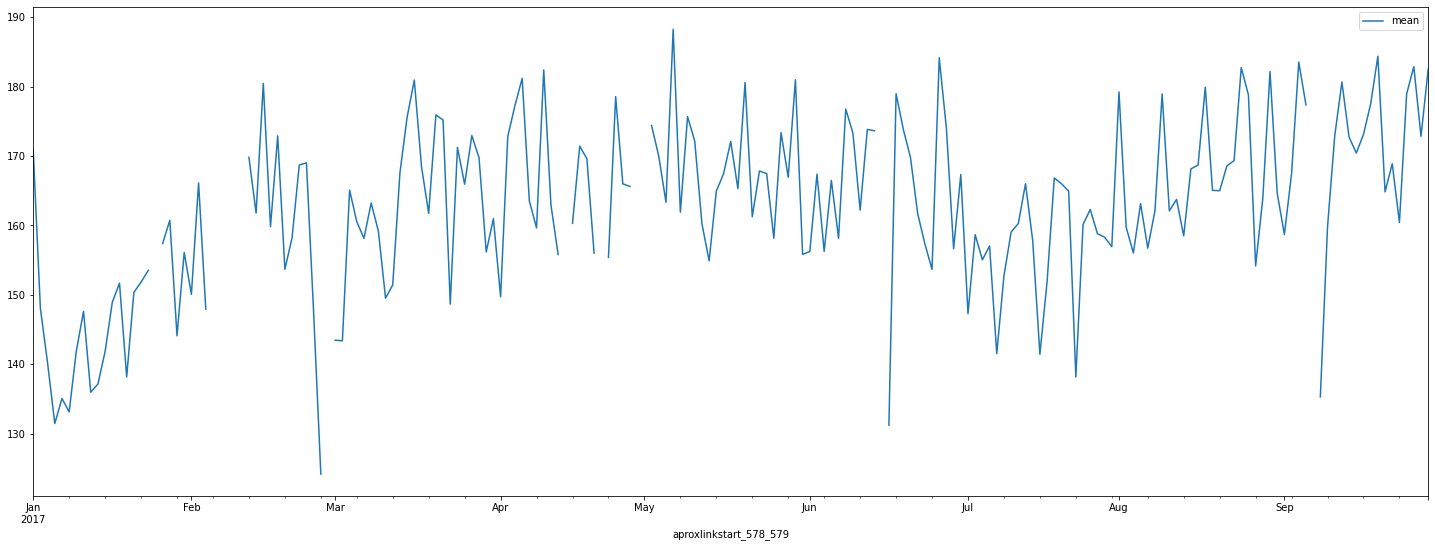

In [15]:
ltt = ts['ltt'].resample('B').apply([np.mean]).plot(figsize=(25, 9))
# Verificando a média dos dias úteis (B - Bussines) verifica-se que existem falhas, algfuns dados faltantes

## **TRATANDO DADOS AUSENTES**

In [16]:
all_days = pd.date_range(start='2017-01-02', end='2017-09-29', freq="B")

def get_randon_day(x):
    x_split = x.split("-")
    x_day_plus_5 = abs(random.randint(2, 28))
    x_day_plus_5 = "{0:0=2d}".format(x_day_plus_5)
    new_x = "-".join([x_split[0], x_split[1], str(x_day_plus_5)])
    return new_x

days_empty = []

for row in all_days:
  x = row.strftime("%Y-%m-%d")
  if len(ts.loc['{}'.format(x)]) == 0:
    days_empty.append('{}'.format(x))

print(days_empty)

for i, day in enumerate(days_empty):
  x_plus = get_randon_day(day)
  while len(ts.loc['{}'.format(x_plus)]) == 0:
      x_plus = get_randon_day(day)
  new_ts = ts.loc['{}'.format(x_plus)]
  day_set = day.split("-")
  day_set = day_set[2]
  new_ts.index = new_ts.index.map(lambda t: t.replace(day=int(day_set)))
  new_ts['day'] = '{}'.format(day_set)
  ts = pd.concat([ts, new_ts])

['2017-01-25', '2017-02-06', '2017-02-07', '2017-02-08', '2017-02-09', '2017-02-10', '2017-02-28', '2017-04-14', '2017-04-21', '2017-04-28', '2017-05-01', '2017-06-15', '2017-09-07']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



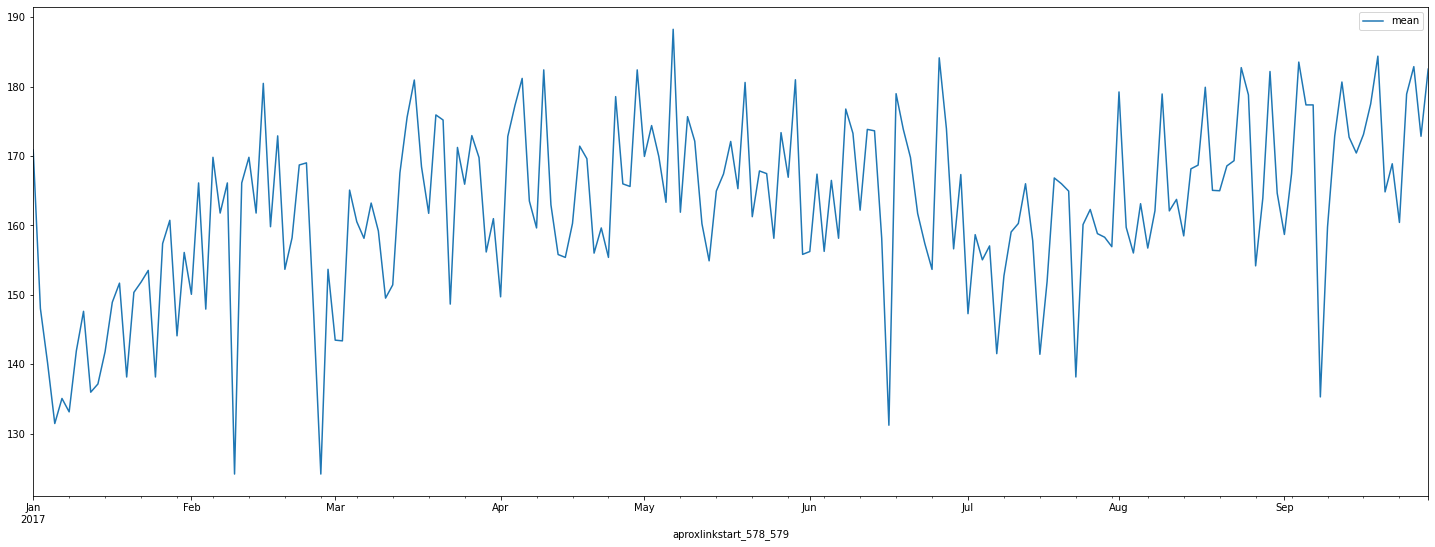

In [17]:
ltt = ts['ltt'].resample('B').apply([np.mean]).plot(figsize=(25, 9))
# Após o tratamento verifica-se que foram preenchidos os dados que estavam ausentes

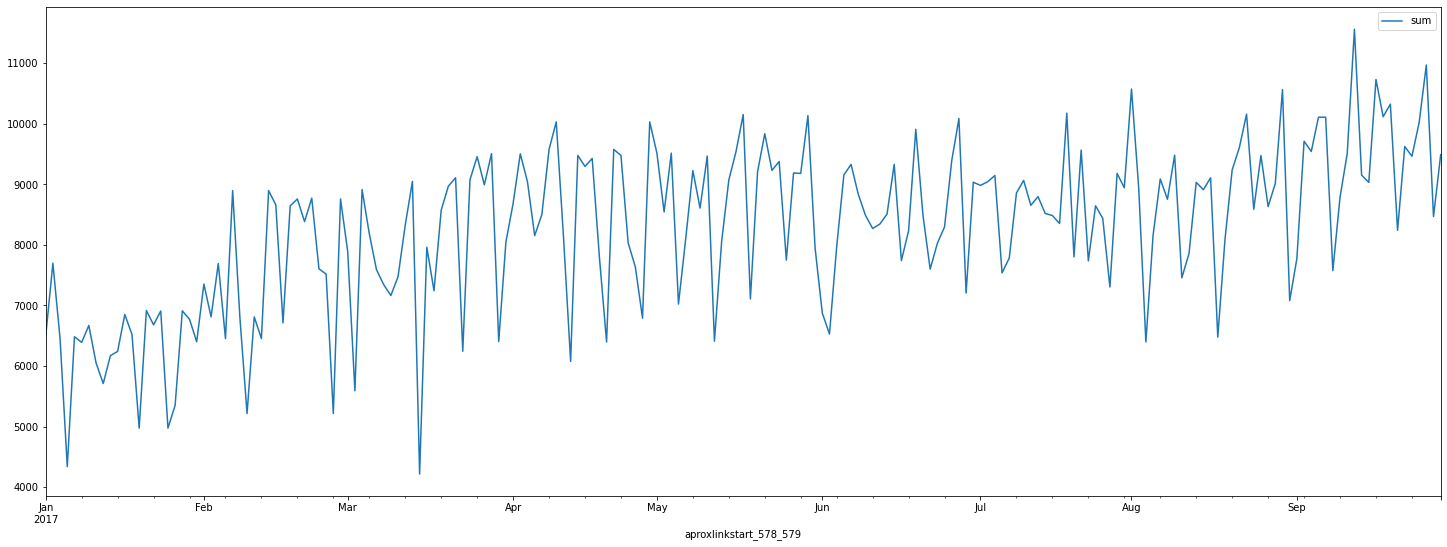

In [18]:
ltt = ts['ltt'].resample('B').apply([np.sum]).plot(figsize=(25, 9))
# somatório dos dias do mes 01 até o mês 09

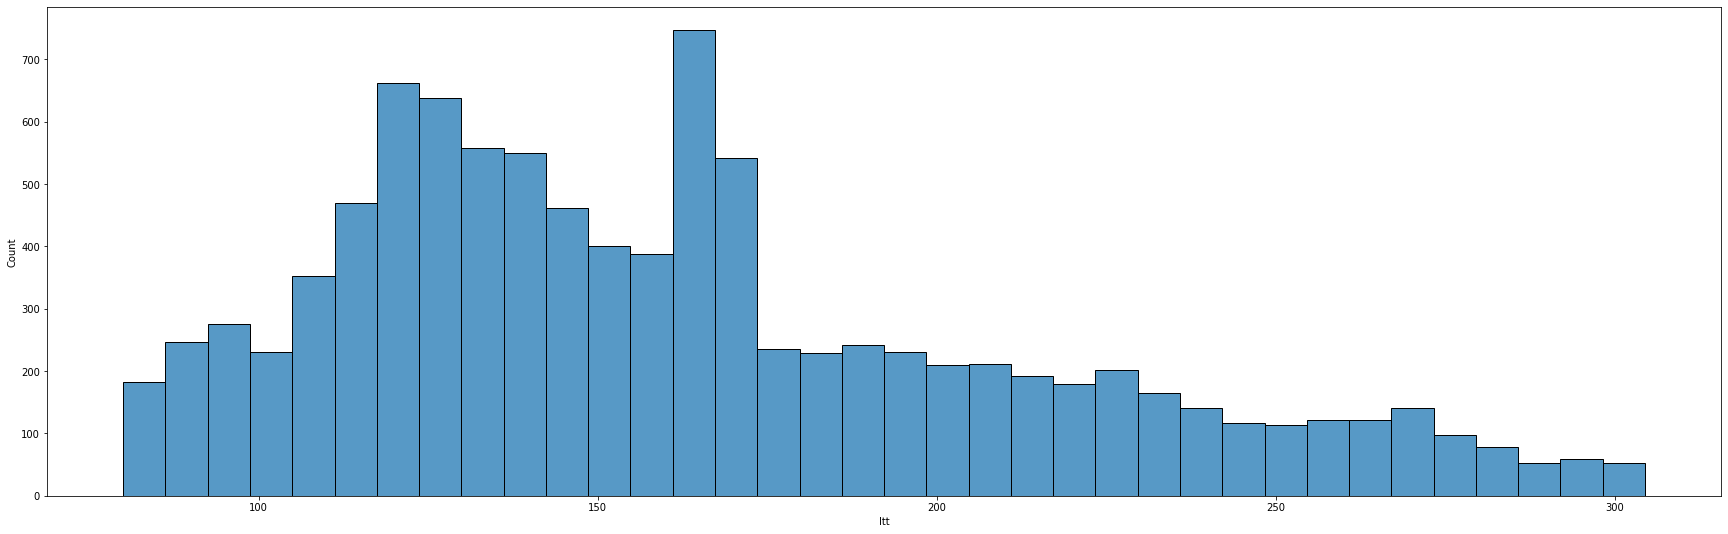

In [19]:
plt.figure(figsize=(30, 9))
sns.histplot(ts['ltt'])

## **Rede Neural**

In [20]:
dataset = ts
dataset = dataset.reset_index(drop=True)
dataset = dataset.drop(['day'], axis=1)
dataset = dataset[['ltt','hour','weekday','month']]
dataset

,ltt,hour,weekday,month
0,121.943000,6,2,1
1,292.307000,7,2,1
2,139.832000,7,2,1
3,172.291631,7,2,1
4,172.291631,7,2,1
...,...,...,...,...
9891,129.819000,21,4,9
9892,166.836930,21,4,9
9893,107.973000,22,4,9
9894,149.339000,23,4,9


In [21]:
dataset['T+1'] = dataset['ltt'].shift(-1)
dataset['T+2'] = dataset['T+1'].shift(-1)
dataset['T+3'] = dataset['T+2'].shift(-1)
dataset['T+4'] = dataset['T+3'].shift(-1)
dataset['T+5'] = dataset['T+4'].shift(-1)
dataset = dataset.fillna(1)
# dataset.isnull()

In [22]:
# separação treino em teste
pct_split = 0.8
train_dataset = dataset.sample(frac=pct_split,random_state=0)
train_dataset
train_dataset

,ltt,hour,weekday,month,T+1,T+2,T+3,T+4,T+5
9199,128.49400,9,6,9,174.651,120.56100,222.249,160.533,220.73300
9274,152.79600,11,2,2,155.215,153.35100,211.204,193.133,205.13100
7480,196.45100,15,3,8,239.581,182.87400,243.327,206.497,288.64100
9664,166.83693,21,2,4,134.437,119.66800,94.803,153.053,166.83693
6681,106.45600,12,3,7,153.999,128.96000,200.862,151.254,166.83693
...,...,...,...,...,...,...,...,...,...
2981,144.58500,11,2,4,135.306,147.63700,160.939,92.144,162.40500
3889,274.88900,17,4,5,272.017,127.62700,204.896,206.293,282.03200
1920,152.00300,23,5,3,111.415,104.62700,128.012,111.946,115.88900
303,141.08100,20,3,1,137.820,166.83693,122.377,98.088,166.83693


In [23]:
# retira dos dados totais, a parte de treino
test_dataset = dataset.drop(train_dataset.index)
test_dataset

,ltt,hour,weekday,month,T+1,T+2,T+3,T+4,T+5
0,121.943,6,2,1,292.30700,139.832000,172.291631,172.291631,172.291631
13,245.373,10,2,1,166.83693,172.291631,172.291631,166.836930,172.291631
21,293.563,15,2,1,228.21700,137.961000,153.844000,119.868000,114.278000
25,119.868,19,2,1,114.27800,142.415000,166.836930,122.978000,114.877000
26,114.278,19,2,1,142.41500,166.836930,122.978000,114.877000,119.447000
...,...,...,...,...,...,...,...,...,...
9851,124.411,8,4,9,195.78800,202.068000,199.911000,253.575000,166.836930
9860,215.845,10,4,9,129.98200,119.269000,225.403000,172.629000,118.827000
9866,144.244,13,4,9,205.18800,163.672000,269.371000,227.519000,111.459000
9869,269.371,13,4,9,227.51900,111.459000,272.873000,262.489000,284.471000


In [24]:
test_dataset.columns

Index(['ltt', 'hour', 'weekday', 'month', 'T+1', 'T+2', 'T+3', 'T+4', 'T+5'], dtype='object')

In [25]:
test_ltt = test_dataset[['ltt']].values
test_ltt

array([[121.943],
       [245.373],
       [293.563],
       ...,
       [144.244],
       [269.371],
       [270.443]])

In [26]:
train_stats = train_dataset.describe()

# Remoção da variável target
train_stats.pop("ltt")


train_stats = train_stats.T
train_stats

,count,mean,std,min,25%,50%,75%,max
hour,7917.0,13.866490,5.321544,6.0,9.000,14.000,19.000,23.000
weekday,7917.0,3.856511,1.416846,2.0,3.000,4.000,5.000,6.000
month,7917.0,5.188960,2.547411,1.0,3.000,5.000,7.000,9.000
T+1,7917.0,163.532520,50.942101,1.0,124.784,154.889,193.929,304.447
T+2,7917.0,163.145040,51.416456,1.0,124.113,153.719,192.804,304.444
T+3,7917.0,162.865438,50.997502,1.0,124.115,154.058,192.664,304.447
T+4,7917.0,162.996037,51.013284,1.0,124.496,153.827,193.147,304.444
T+5,7917.0,163.260911,51.146537,1.0,124.496,154.306,193.821,304.447


In [27]:
# Separação e variáveis preditoras (label) a variável target
# variável target: variável que o modelo pretende prever
# variáveis preditoras: variáveis utilizadas como input para o modelo realizar a previsão
    
train_labels = train_dataset.pop('ltt')
test_labels = test_dataset.pop('ltt')

In [28]:
#função de normalização dados - criando função de normalização
def nomalize(x):
    return (x - train_stats['mean']) / train_stats['std']

In [29]:
#normalizando dados previsores
normed_train_data = nomalize(train_dataset)
normed_test_data = nomalize(test_dataset)

In [30]:
def model_one():
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [31]:
model = model_one()
model

In [32]:
train_dataset.keys()

Index(['hour', 'weekday', 'month', 'T+1', 'T+2', 'T+3', 'T+4', 'T+5'], dtype='object')

In [33]:
# Caracteristica da rede neural
# modelo sequencial, com camadas densamente conectadas
# Função de ativação selu (Scaled Exponential Linear Unit) 
# output de um valor numérico, na última camada
# Função de custo Erro Quadrado Médio (Mean Squared Error)
# 1000 epocas
# Função do otimização Adam
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                576       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 17,217
Trainable params: 17,217
Non-trainable params: 0
_________________________________________________________________


In [34]:
## classe mostra progresso
class Progresso(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: 
      print('')
    print('*', end='')

In [35]:
#Treinamento do model one
EPOCHS = 1000

history = model.fit(
    x=normed_train_data,
    y=train_labels,
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=0,
    callbacks=[Progresso()]
)


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
******************************************************************************************

In [36]:
history.__dict__.keys()

dict_keys(['validation_data', 'model', '_chief_worker_only', '_supports_tf_logs', 'history', 'params', 'epoch'])

In [37]:
history.history.keys()

dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])

In [38]:
historico = pd.DataFrame(history.history)
historico['epoch'] = history.epoch
historico.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,359.375458,14.408066,359.375458,3491.911377,45.322048,3491.911377,995
996,350.199127,14.264731,350.199127,3527.470215,45.423862,3527.470215,996
997,362.589325,14.436769,362.589325,3348.329346,44.372723,3348.329346,997
998,358.035767,14.412983,358.035767,3283.872559,44.003441,3283.872559,998
999,358.491791,14.520943,358.491791,3271.923828,43.841492,3271.923828,999


In [39]:
historico.describe()


,loss,mae,mse,val_loss,val_mae,val_mse,epoch
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,955.343592,23.465040,955.343592,2633.106761,39.876675,2633.106761,499.500000
std,534.353376,6.836646,534.353376,473.395945,2.943136,473.395945,288.819436
min,350.199127,14.264731,350.199127,1862.504150,34.573395,1862.504150,0.000000
25%,510.623863,17.315331,510.623863,2200.222656,37.364416,2200.222656,249.750000
50%,801.102600,21.981904,801.102600,2650.979248,39.880228,2650.979248,499.500000
75%,1361.268402,29.398311,1361.268402,3072.684937,42.485275,3072.684937,749.250000
max,7330.988281,64.797546,7330.988281,3615.591553,46.416195,3615.591553,999.000000


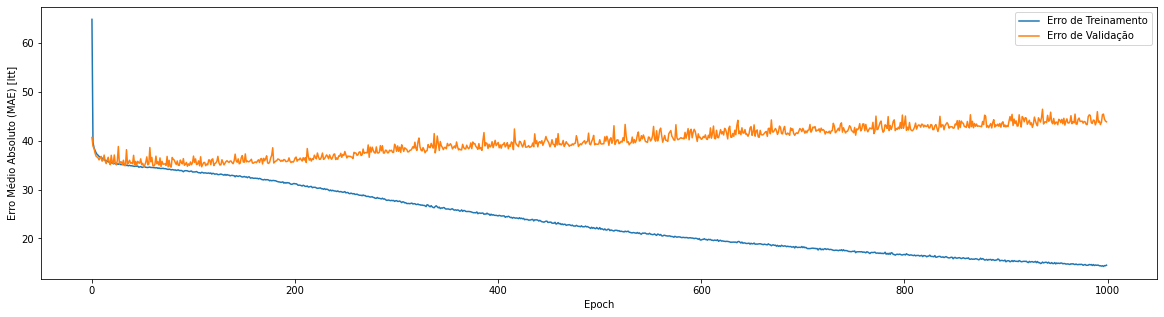

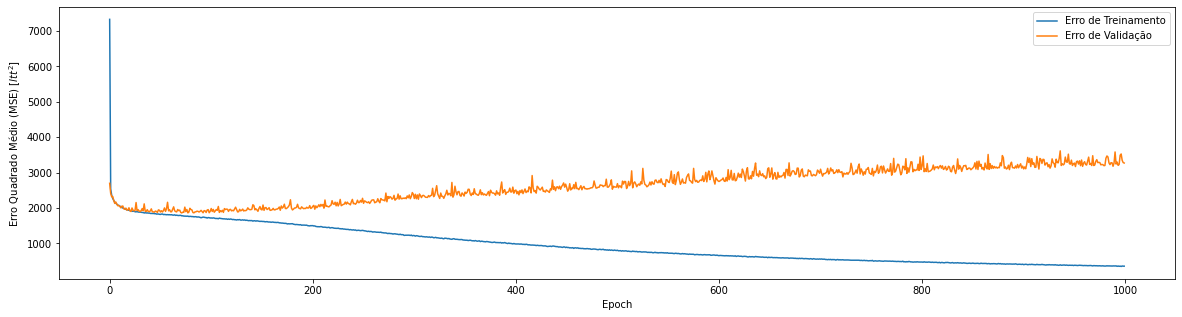

In [40]:
def plota_historico(history, limita=False):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(20,5))
  plt.xlabel('Epoch')
  plt.ylabel('Erro Médio Absoluto (MAE) [ltt]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Erro de Treinamento')
  plt.legend(loc='best', fontsize=25)
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Erro de Validação')
  plt.legend(loc='best', fontsize=25)
  if limita == True:
    plt.ylim([0,5])
  plt.legend()

  plt.figure(figsize=(20,5))
  plt.xlabel('Epoch')
  plt.ylabel('Erro Quadrado Médio (MSE) [$ltt^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Erro de Treinamento')
  plt.legend(loc='best', fontsize=25)
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Erro de Validação')
  plt.legend(loc='best', fontsize=25)
  if limita == True:
    plt.ylim([0,20])
  plt.legend()
  plt.show()


plota_historico(history)


******************************************

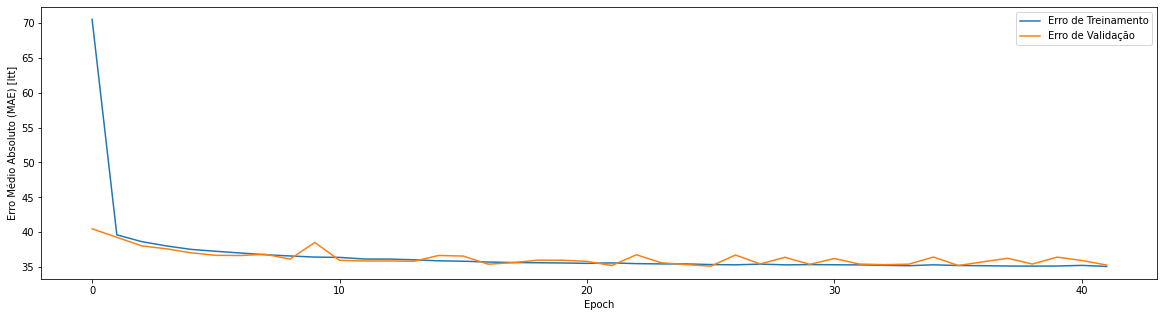

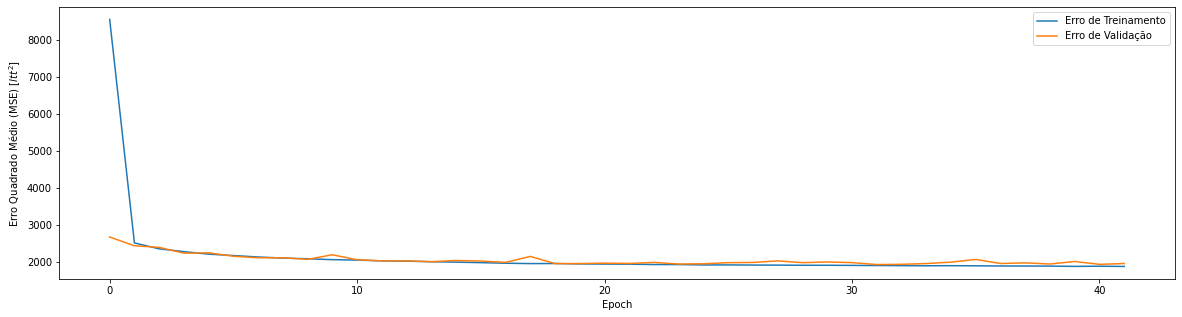

In [41]:
model = model_one()

# O paramêtro patience é o quantidade de epochs para checar as melhoras
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
    normed_train_data, 
    train_labels, 
    epochs=EPOCHS,
    validation_split = 0.2, 
    verbose=0, 
    callbacks=[early_stop, Progresso()])

plota_historico(history)

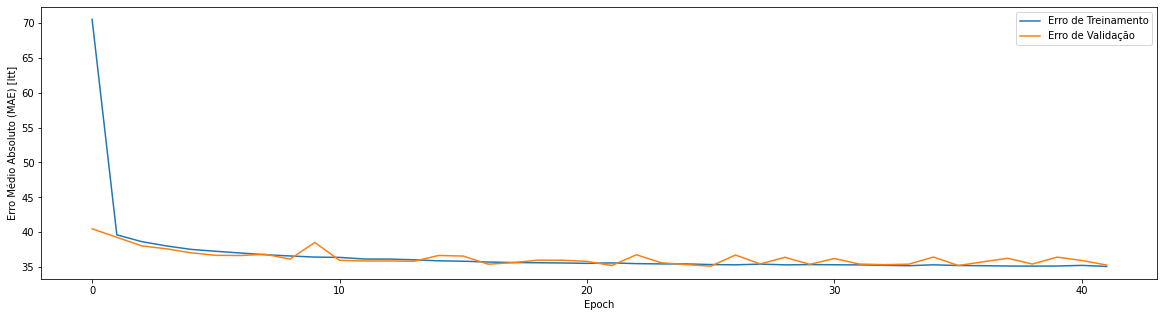

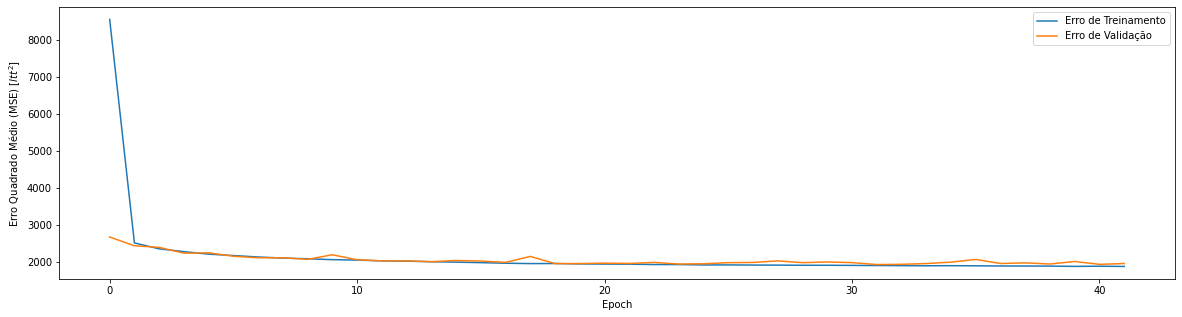

In [42]:
plota_historico(history)

In [43]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print(" \n Erro Absoluto Médio calculado nos testes Teste: {:5.2f}\n ".format(mae))

62/62 - 0s - loss: 1900.2454 - mae: 34.6135 - mse: 1900.2454
 
 Erro Absoluto Médio calculado nos testes Teste: 34.61
 


In [44]:
train_dataset

,hour,weekday,month,T+1,T+2,T+3,T+4,T+5
9199,9,6,9,174.651,120.56100,222.249,160.533,220.73300
9274,11,2,2,155.215,153.35100,211.204,193.133,205.13100
7480,15,3,8,239.581,182.87400,243.327,206.497,288.64100
9664,21,2,4,134.437,119.66800,94.803,153.053,166.83693
6681,12,3,7,153.999,128.96000,200.862,151.254,166.83693
...,...,...,...,...,...,...,...,...
2981,11,2,4,135.306,147.63700,160.939,92.144,162.40500
3889,17,4,5,272.017,127.62700,204.896,206.293,282.03200
1920,23,5,3,111.415,104.62700,128.012,111.946,115.88900
303,20,3,1,137.820,166.83693,122.377,98.088,166.83693


In [50]:
test_labels

0       121.943
13      245.373
21      293.563
25      119.868
26      114.278
         ...   
9851    124.411
9860    215.845
9866    144.244
9869    269.371
9879    270.443
Name: ltt, Length: 1979, dtype: float64

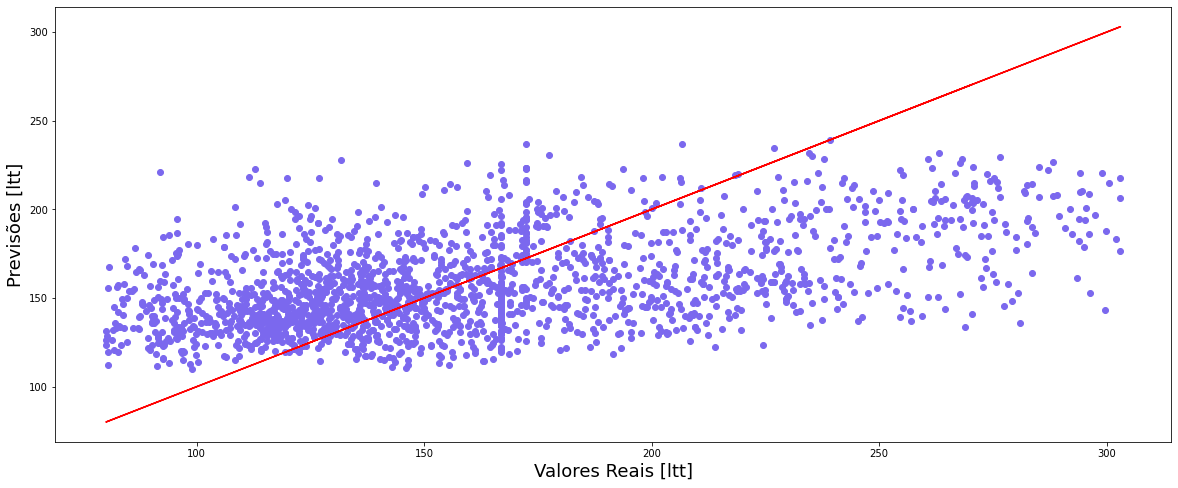

In [45]:
#Previsões
previsoes_teste = model.predict(normed_test_data).flatten()
plt.figure(figsize=(20,8))
plt.scatter(test_labels, previsoes_teste, color="mediumslateblue")
plt.plot(test_ltt, test_labels, color="red")
plt.xlabel('Valores Reais [ltt]', fontsize=18)
plt.ylabel('Previsões [ltt]', fontsize=18)

plt.show()

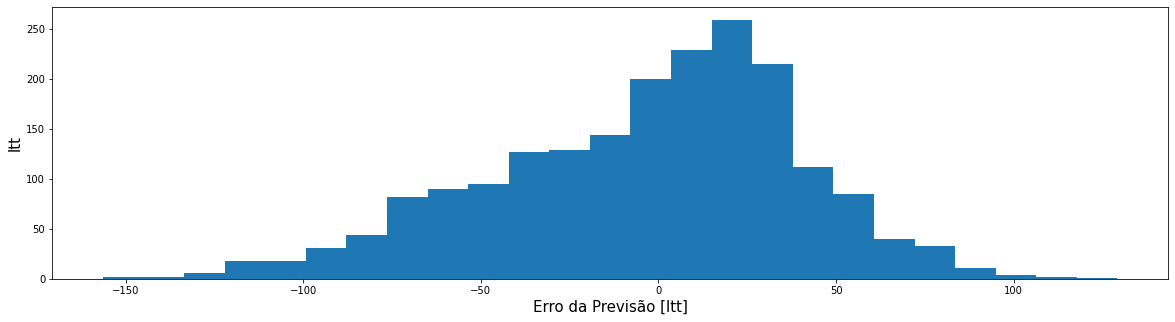

In [46]:
# Verifica a distribuição dos erros se são de distribuição aproximadamente Gaussiana
plt.figure(figsize=(20,5))
erro = previsoes_teste - test_labels
plt.hist(erro, bins = 25)
plt.xlabel("Erro da Previsão [ltt]", fontsize=15)
_ = plt.ylabel("ltt", fontsize=15)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



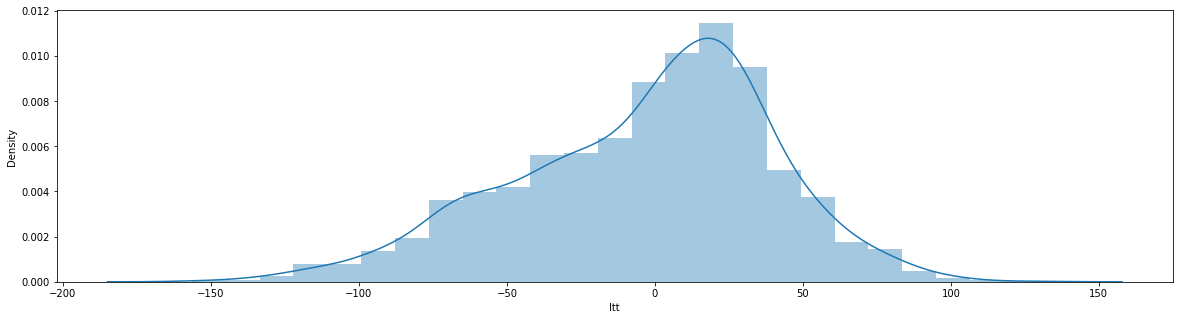

In [47]:
plt.figure(figsize=(20,5))
sns.distplot(a=erro, bins=25)
plt.show()